In [1]:
import os

mgf_file = "/mnt/data/cdens/casanovo-scaling/massivekb_data/massiveKB_3cac0386.mgf"
cache_dir = "/mnt/data/cdens/casanovo-scaling/massivekb_data/massiveKB_3cac0386_charge"
os.makedirs(cache_dir, exist_ok=True)

In [13]:
from analysis import create_sub_mgf

# cache_dir = "/mnt/data/cdens/casanovo-scaling/massivekb_data/massiveKB_3cac0386_sub"
# os.makedirs(cache_dir, exist_ok=True)

# Create the sub file and set the mgf file to the sub mgf
# mgf_file = create_sub_mgf(mgf_file, cache_dir, num_spectra=10000)

In [27]:
from analysis import create_sequence_index

df = create_sequence_index(mgf_file, cache_dir, total=int(66e6))
unique_sequences = list(df["unmodified_sequence"].unique())

In [28]:
from dist_matrix import square_dist_matrix
import random
import numpy as np

n_datasail = 100000

random_seqs_cache_file = os.path.join(cache_dir, f"sequences_{n_datasail}.npy")
if os.path.exists(random_seqs_cache_file):
    random_seqs = np.load(random_seqs_cache_file, allow_pickle=True)

else:
    random_seqs = random.sample(unique_sequences, n_datasail)
    np.save(random_seqs_cache_file, random_seqs, allow_pickle=True)

dist_matrix = square_dist_matrix(random_seqs, cache_dir, n_threads=16)

In [29]:
from analysis import split_datasail, get_train_val_test

split_df = split_datasail(random_seqs, dist_matrix, [0.96, 0.02, 0.02], e_clusters=200, epsilon=0.1, threads=16,
                          cache_dir=cache_dir, from_cache=True)
train, val, test = get_train_val_test(split_df)
total = len(random_seqs)
print(f"\nDatasail produced following splits: (total={total})")
print(f"TRAIN: {len(train)} ({len(train) * 100 / total:.2f}%)")
print(f"VAL:   {len(val)} ({len(val) * 100 / total:.2f}%)")
print(f"TEST:  {len(test)} ({len(test) * 100 / total:.2f}%)")


Datasail produced following splits: (total=100000)
TRAIN: 96167 (96.17%)
VAL:   1938 (1.94%)
TEST:  1895 (1.90%)


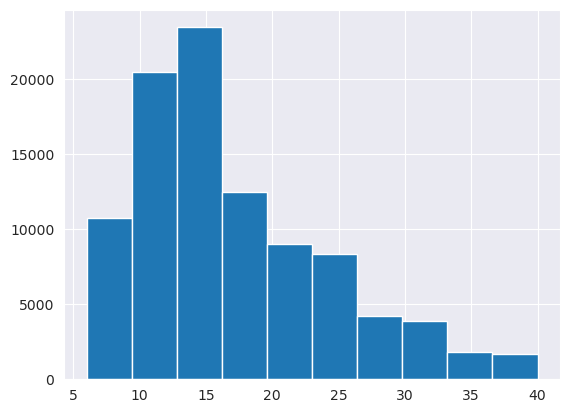

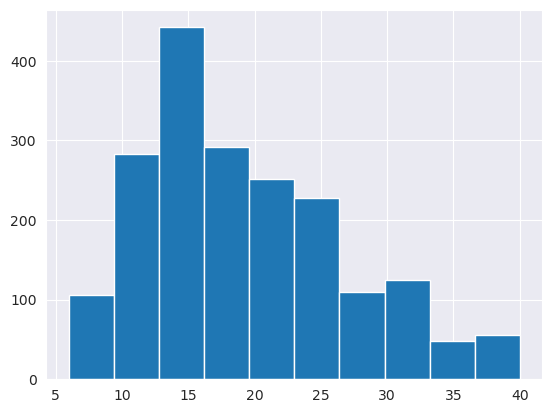

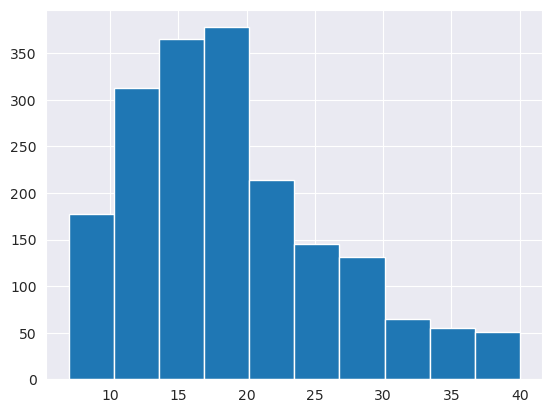

In [30]:
import matplotlib.pyplot as plt

plt.hist(train['sequence'].str.len())
plt.show()

plt.hist(val['sequence'].str.len())
plt.show()

plt.hist(test['sequence'].str.len())
plt.show()

In [31]:
from analysis import add_all_to_split

full_split_df = add_all_to_split(split_df, unique_sequences, n_threads=48, cache_dir=cache_dir, from_cache=True)


Adding all unmodified sequences produced following splits: (total=2512045)
TRAIN: 2446625 (97.40%)
VAL:   31926 (1.27%)
TEST:  33494 (1.33%)


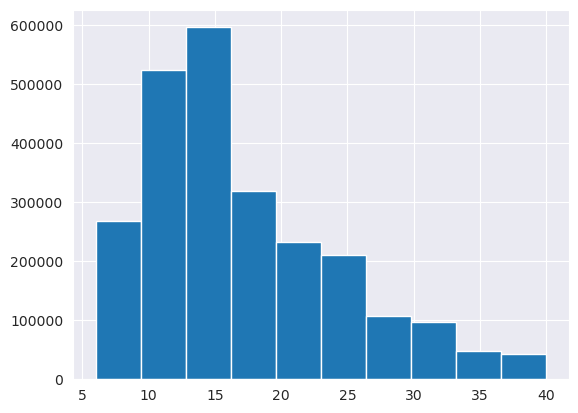

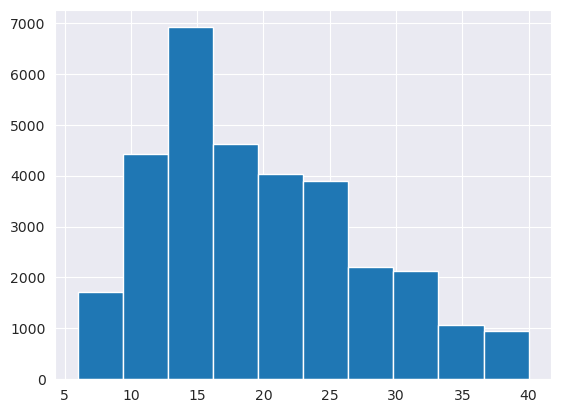

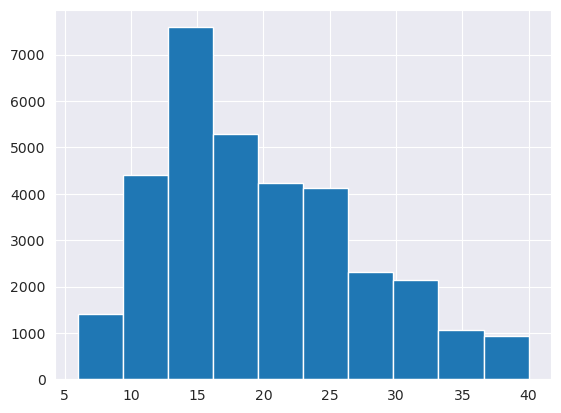

In [32]:
import matplotlib.pyplot as plt

train, val, test = get_train_val_test(full_split_df)
total = len(full_split_df)
print(f"\nAdding all unmodified sequences produced following splits: (total={total})")
print(f"TRAIN: {len(train)} ({len(train) * 100 / total:.2f}%)")
print(f"VAL:   {len(val)} ({len(val) * 100 / total:.2f}%)")
print(f"TEST:  {len(test)} ({len(test) * 100 / total:.2f}%)")

plt.hist(train['sequence'].str.len())
plt.show()

plt.hist(val['sequence'].str.len())
plt.show()

plt.hist(test['sequence'].str.len())
plt.show()

In [33]:
from analysis import create_val_test_traini

# From now on, no more caching

output_dir = os.path.join(cache_dir, "subsets")
exclude_ptms = ['+28.031', '+10.008', '+8.014', '+34.063', '+114.043', '+229.163+42.011', '+229.163+43.006',
                '+229.163-17.027', '+34.063-17.027']

# First, iterate over the full mgf again and create val.mgf and test.mgf, also create the train index
indexed_mgf_reader, train_index = create_val_test_traini(mgf_file, full_split_df, exclude_ptms, output_dir, total=66e6)

66120315it [2:13:35, 8248.72it/s]                                   


In [34]:
import pickle
pickle.dump((indexed_mgf_reader, train_index), open(os.path.join(cache_dir, "train_index.pkl"), "wb"))

In [2]:
import pickle
output_dir = os.path.join(cache_dir, "subsets")
indexed_mgf_reader, train_index = pickle.load(open(os.path.join(cache_dir, "train_index.pkl"), "rb"))

In [ ]:
from analysis import create_train_subsets

# n_train_spectra = [1, 2, 5, 10, 20]
n_train_spectra = [20]
# n_train_peps = [int(i) for i in [1e5, 5e5, 1e6, 2e6, 3e6]] + [None]
n_train_peps = [None]

create_train_subsets(indexed_mgf_reader, train_index, n_train_spectra, n_train_peps, output_dir)

There are 773593 peptides with at least 20 spectra
Getting 20 spectra for 4243254 peptides
Got 15471860 spectra from peptides with enough spectra
Added all spectra from random peptides, selected 28512877 spectra in total now


Writing train_20s_4243254p.mgf:   1%|          | 147728/28512877 [01:02<3:37:10, 2176.89it/s]